#### Grounded Segment Anthing

In [30]:
import argparse
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "0"
import copy
import torch
import numpy as np
import cv2
import PIL
from PIL import Image, ImageDraw, ImageFont
import matplotlib.pyplot as plt
from torchvision.ops import box_convert

# Grounding DINO
import GroundingDINO.groundingdino.datasets.transforms as T
from GroundingDINO.groundingdino.models import build_model
from GroundingDINO.groundingdino.util import box_ops
from GroundingDINO.groundingdino.util.slconfig import SLConfig
from GroundingDINO.groundingdino.util.utils import clean_state_dict, get_phrases_from_posmap
from groundingdino.util.inference import annotate, load_image, predict
import supervision as sv

# segment anything
from segment_anything import build_sam, SamPredictor 

# diffusers
import requests
from io import BytesIO
from diffusers import StableDiffusionInpaintPipeline
from huggingface_hub import hf_hub_download

#### Load Grounding DINO model

In [31]:
def load_model_hf(repo_id, filename, ckpt_config_filename, device='cpu'):
    cache_config_file = hf_hub_download(repo_id=repo_id, filename=ckpt_config_filename)

    args = SLConfig.fromfile(cache_config_file) 
    model = build_model(args)
    args.device = device

    cache_file = hf_hub_download(repo_id=repo_id, filename=filename)
    checkpoint = torch.load(cache_file, map_location='cpu')
    log = model.load_state_dict(clean_state_dict(checkpoint['model']), strict=False)
    print("Model loaded from {} \n => {}".format(cache_file, log))
    _ = model.eval()
    return model   

In [ ]:
# Use this command for evaluate the Grounding DINO model
ckpt_repo_id = "ShilongLiu/GroundingDINO"
ckpt_filenmae = "groundingdino_swinb_cogcoor.pth"
ckpt_config_filename = "GroundingDINO_SwinB.cfg.py"
groundingdino_model = load_model_hf(ckpt_repo_id, ckpt_filenmae, ckpt_config_filename)

#### Load SAM model

In [34]:
sam_checkpoint = 'sam_vit_h_4b8939.pth'
sam_predictor = SamPredictor(build_sam(checkpoint=sam_checkpoint))

#### Load stable diffusion inpainting models

In [35]:
from diffusers import StableDiffusionInpaintPipeline

pipe = StableDiffusionInpaintPipeline.from_pretrained("stabilityai/stable-diffusion-2-inpainting", torch_dtype=torch.float16)
pipe = pipe.to("cuda")

Fetching 13 files:   0%|          | 0/13 [00:00<?, ?it/s]

#### Load demo image

In [36]:
def download_image(url, image_file_path):
    r = requests.get(url, timeout=4.0)
    if r.status_code != requests.codes.ok:
        assert False, 'Status code error: {}.'.format(r.status_code)
    with Image.open(io.BytesIO(r.content)) as im:
        im.save(image_file_path)
    print('Image downloaded from url: {} and saved to: {}.'.format(url, image_file_path))

# download_image(image_url, local_image_path)
local_image_path = 'assets/inpaint_demo.jpg'

#### Run Grounding DINO for detection

In [40]:
TEXT_PROMPT = "bench"
BOX_TRESHOLD = 0.3
TEXT_TRESHOLD = 0.25
image_source, image = load_image(local_image_path)
boxes, logits, phrases = predict(model=groundingdino_model,  image=image, 
                    caption=TEXT_PROMPT, box_threshold=BOX_TRESHOLD, text_threshold=TEXT_TRESHOLD)

annotated_frame = annotate(image_source=image_source, boxes=boxes, logits=logits, phrases=phrases)
annotated_frame = annotated_frame[...,::-1] # BGR to RGB

PIL.Image.fromarray(image_source)
Image.fromarray(annotated_frame)

#### Run the segmentation model

In [ ]:
# set image, box (normalized box xywh -> unnormalized xyxy)
sam_predictor.set_image(image_source)
H, W, _ = image_source.shape
boxes_xyxy = box_ops.box_cxcywh_to_xyxy(boxes) * torch.Tensor([W, H, W, H])

transformed_boxes = sam_predictor.transform.apply_boxes_torch(boxes_xyxy, image_source.shape[:2])
masks, _, _ = sam_predictor.predict_torch(
            point_coords = None,
            point_labels = None,
            boxes = transformed_boxes,
            multimask_output = False,
        )

In [18]:
def show_mask(mask, image, random_color=True):
    if random_color:
        color = np.concatenate([np.random.random(3), np.array([0.8])], axis=0)
    else:
        color = np.array([30/255, 144/255, 255/255, 0.6])
    h, w = mask.shape[-2:]
    mask_image = mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
    
    annotated_frame_pil = Image.fromarray(image).convert("RGBA")
    mask_image_pil = Image.fromarray((mask_image.cpu().numpy() * 255).astype(np.uint8)).convert("RGBA")
    return np.array(Image.alpha_composite(annotated_frame_pil, mask_image_pil))

annotated_frame_with_mask = show_mask(masks[0][0], annotated_frame)
Image.fromarray(annotated_frame_with_mask)

#### Image Inpainting

In [21]:
image_mask = masks[0][0].cpu().numpy()
image_source_pil = Image.fromarray(image_source)
annotated_frame_pil = Image.fromarray(annotated_frame)
image_mask_pil = Image.fromarray(image_mask)
annotated_frame_with_mask_pil = Image.fromarray(annotated_frame_with_mask)

# mask result
image_mask_pil

In [24]:
# resize for inpaint
image_source_for_inpaint = image_source_pil.resize((512, 512))
image_mask_for_inpaint = image_mask_pil.resize((512, 512))

prompt = "A sofa, high quality, detailed, cyberpunk, futuristic, with a lot of details, and a lot of colors."
#image and mask_image should be PIL images. (mask: white for inpainting)
image_inpainting = pipe(prompt=prompt, image=image_source_for_inpaint, mask_image=image_mask_for_inpaint).images[0]
image_inpainting = image_inpainting.resize((image_source_pil.size[0], image_source_pil.size[1]))
image_inpainting

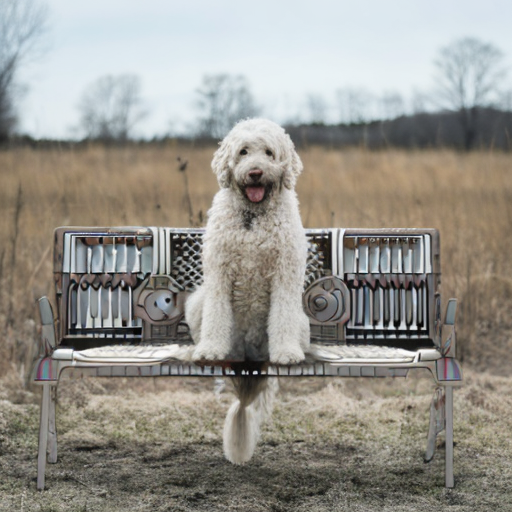

In [27]:
image_inpainting